# Data Scientist Professional Case Study

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

# Imports

In [2]:
# import all necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Select a Performance Metric

In [3]:

# Looks like the Mean Absolute Percentage Error (MAPE) is wat the client expects
my_metric = 'neg_mean_absolute_percentage_error'

# Get the data

In [4]:

df = pd.read_csv('data/boat_data.csv')

# Inspect the data

In [5]:

df.head().append(df.tail())

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58
9883,CHF 4900,Sport Boat,Sea Ray power boats,"Used boat,Unleaded",1987,6.30,2.44,NaN,Switzerland Â» Lago Maggiore Â» Riazzino,1116
9884,EUR 4516,Sport Boat,NaN,new boat from stock,0,4.17,1.68,GRP,Germany Â» Hamburg Â» HAMBURG,94
9885,EUR 4499,Sport Boat,BlueCraft power boats,"new boat from stock,Unleaded",2020,4.40,1.80,GRP,Germany Â» Nordrhein-Westfalen Â» Wesel,354
9886,EUR 4300,Pontoon Boat,Whaly power boats,new boat from stock,2018,4.37,1.89,NaN,Italy Â» Dormelletto,266
9887,CHF 3780,Fishing Boat,DarekCo power boats,new boat from stock,2019,3.60,1.60,GRP,Switzerland Â» Brienzersee Â» Brienz,194


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


In [9]:
df.describe()

,Year Built,Length,Width,Number of views last 7 days
count,9888.000000,9879.000000,9832.000000,9888.000000
mean,1893.192860,11.570017,3.520124,149.160801
std,460.201582,6.002820,1.220534,151.819752
min,0.000000,1.040000,0.010000,13.000000
25%,1996.000000,7.470000,2.540000,70.000000
50%,2007.000000,10.280000,3.330000,108.000000
75%,2017.000000,13.930000,4.250000,172.000000
max,2021.000000,100.000000,25.160000,3263.000000


We can see there are missing values and the Price column is object, but the dataset is quite clean and decently large. Let's take a look at how the data relates to each other

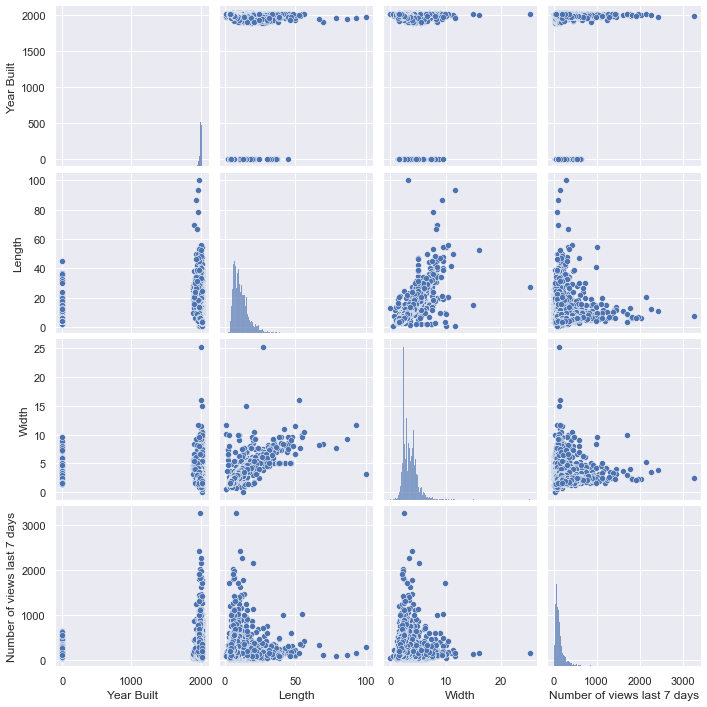

In [10]:


sns.pairplot(df)
plt.show()

We can see that our target has a correlation with Length and Width, maybe there is a relation with the Year Built feature, but it's hard to tell, also, there is no Price here yet. We'll get back to this visualization after cleaning the data. 

# Clean the data

In [11]:
# check how many missing values we have
df.isnull().sum()

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64

In [12]:
# how many rows will we lose if sacrifice all of the missing values?
((len(df)) - len(df.dropna())) / len(df)

0.2901496763754045

30% of the dataset, this is too much, let's try to work with the data

## Manufacturer

In [14]:
df.Manufacturer.value_counts(dropna=False)


NaN                       1338
BÃ©nÃ©teau power boats     631
Jeanneau power boats       537
Sunseeker power boats      383
Princess power boats       241
                          ... 
Klase A power boats          1
Fidego power boats           1
D-Boat power boats           1
Barro power boats            1
Technus power boats          1
Name: Manufacturer, Length: 911, dtype: int64

The first word often represents the manufecturer name but not always. For example 'Sea' is 'Sea Ray' so you need to do more sophisticated cleaning here. Also the NaN is the top group. This is a potencially useful feature, maybe we will use it later.

In [15]:
df.Manufacturer.str.split(' ').str[0].value_counts(normalize=True, dropna=False).cumsum().head(20)

NaN            0.135316
BÃ©nÃ©teau     0.199130
Jeanneau       0.253439
Sunseeker      0.292172
Quicksilver    0.321096
Sea            0.345469
Princess       0.369842
Cranchi        0.391990
Azimut         0.413734
Bavaria        0.432443
Fairline       0.449838
Sessa          0.464806
Bayliner       0.479167
Sealine        0.491303
Prestige       0.502225
Galeon         0.511731
Regal          0.520833
Riva           0.528722
Linssen        0.535801
Windy          0.542476
Name: Manufacturer, dtype: float64

## Material

In [16]:
df.Material.value_counts(dropna=False)

GRP                    5484
NaN                    1749
PVC                    1123
Steel                   939
Wood                    235
Aluminium               229
Plastic                  77
Carbon Fiber             30
Thermoplastic            15
Hypalon                   5
Reinforced concrete       1
Rubber                    1
Name: Material, dtype: int64

I can't see a clear way to infer the missing material looking at other columns. We will probably Impute with the most frequent value later

## Boat Type

In [18]:
# There is a lot of groups repeating each other. Let's try to unify them.

df['Boat Type'].value_counts()

Motor Yacht                           2720
Sport Boat                            1407
Flybridge                             1194
Trawler                                679
Pilothouse                             613
                                      ... 
Cabin Boat,Motor Yacht,Trawler           1
Fishing Boat,Launch,Motor Yacht          1
Classic,Motor Yacht,Passenger boat       1
Motor Yacht,Sport Boat,Water ski         1
Bowrider,Deck Boat,Water ski             1
Name: Boat Type, Length: 126, dtype: int64

In [19]:
# 20 groups cover 96% of listing entries while 100 cover only 4%. These 4% are still around 600 rows, we can't just drop them.
df['Boat Type'].value_counts(normalize=True).cumsum().head(20)

Motor Yacht            0.275081
Sport Boat             0.417375
Flybridge              0.538127
Trawler                0.606796
Pilothouse             0.668790
Cabin Boat             0.727953
Hardtop                0.779227
Center console boat    0.816545
Bowrider               0.846986
Deck Boat              0.875607
Fishing Boat           0.893103
House Boat             0.907767
Mega Yacht             0.918689
Pontoon Boat           0.927892
Runabout               0.935275
Classic,Runabout       0.941242
Classic                0.947209
Wakeboard/Wakesurf     0.953074
Launch                 0.958637
Offshore Boat          0.964098
Name: Boat Type, dtype: float64

In [7]:
df1 = df.copy() # we are going to change the dataframe so let's first create a copy.

Apperently we have five main groups that have lots of derivatives which can by replaced by key words: Motor Yacht, Sport Boat, Classic and Cabin boat. Let's unify them

In [8]:
boat_type_keywords = ['Motor Yacht', 'Sport Boat', 'Classic', 'Cabin', 'Wakeboard', 'Fishing', 'Center console boat', 'Passenger boat', 'Bowrider', 'Deck Boat', 'Flybridge', 'Offshore Boat']

def unify_boat_type(my_keywords = boat_type_keywords):
    
    '''sequentially replaces group names according to the order in the boat_type_keywords list '''
    
    df1['Boat Type'] = df1['Boat Type'].str.strip()
    
    for i in my_keywords:
        df1.loc[df1['Boat Type'].str.contains(i), 'Boat Type'] = i
unify_boat_type()

In [9]:
# now the boat types are unified
df1['Boat Type'].value_counts(normalize=True).cumsum()

Motor Yacht            0.284385
Sport Boat             0.433354
Flybridge              0.554207
Trawler                0.622876
Pilothouse             0.684871
Cabin                  0.745955
Hardtop                0.797229
Center console boat    0.834648
Bowrider               0.865190
Deck Boat              0.893912
Fishing                0.911711
Classic                0.928398
House Boat             0.943062
Mega Yacht             0.953985
Pontoon Boat           0.963188
Runabout               0.970570
Wakeboard              0.976739
Launch                 0.982302
Offshore Boat          0.987864
Working Boat           0.992314
Passenger boat         0.995854
Catamaran              0.998483
Water ski              0.999494
Motorsailer            0.999798
Ketch                  0.999899
RIB                    1.000000
Name: Boat Type, dtype: float64

## Type

Although it looks messy, there is logic in this feature. There are two essenses are combined there: the fuel type and whether a boat is new or not.

In [24]:
df1.Type.value_counts(dropna=False, normalize=True).cumsum()

Used boat,Diesel                0.418689
Used boat,Unleaded              0.589199
Used boat                       0.737055
new boat from stock,Unleaded    0.849009
new boat from stock             0.916262
new boat from stock,Diesel      0.945692
new boat on order,Unleaded      0.960862
Display Model,Unleaded          0.968447
new boat on order,Diesel        0.974616
new boat on order               0.980785
Diesel                          0.986549
Used boat,Electric              0.989280
Unleaded                        0.991505
Display Model,Diesel            0.993426
new boat from stock,Electric    0.995247
Display Model                   0.997067
Used boat,Gas                   0.998078
Display Model,Electric          0.998685
NaN                             0.999292
new boat from stock,Gas         0.999494
Used boat,Hybrid                0.999595
Display Model,Gas               0.999697
Electric                        0.999798
new boat from stock,Hybrid      0.999899
Used boat,Propan

I will try to split it into two different features: fuel and new_used

## Fuel

In [10]:
# There are missing values, I will replace them with the most frequent value.

df1.Type.fillna(df1.Type.value_counts().index[0], inplace=True) # change made!

fuel_keywords = ['Diesel', 'Leaded', 'Unleaded', 'Gas', 'Electric', 'Hybrid', 'Propane']
df1['fuel'] = pd.Series(dtype='object')

def create_fuel(my_keywords = fuel_keywords):    
    
    '''sequentially find boat fuel type according to the order in the boat_type_keywords list and record it to df1.fuel '''    
       
    for i in my_keywords:        
        df1.loc[df1.Type.str.contains(i), 'fuel'] = i
    df1.fuel.fillna('Leaded', inplace=True)

create_fuel()

## New_used

In [11]:
# the first word is almost always right

df1['new_used'] = df1.Type.str.split().str[0] 
df1.loc[(df1.new_used != 'new') & (df1.new_used != 'Used'), 'new_used'] = 'Used'

# Now that we have two different features we don't need Type anymore
df1.drop(columns=['Type'], inplace=True)


In [89]:
print(df1.new_used.value_counts(dropna=False))
print(df1.fuel.value_counts(dropna=False))

Used    7532
new     2356
Name: new_used, dtype: int64
Diesel      4574
Unleaded    3040
Leaded      2206
Electric      52
Gas           13
Hybrid         2
Propane        1
Name: fuel, dtype: int64


## Year Built

In [12]:
df1['Year Built'].value_counts(dropna=False)

2020    1279
2019     663
0        551
2008     457
2006     393
        ... 
1902       1
1912       1
1885       1
1941       1
1900       1
Name: Year Built, Length: 122, dtype: int64

In [13]:
# There are 551 zeros in this feature. I will replace them with the most frequent year built value

df1['Year Built'].replace(0, df1['Year Built'].value_counts().index[0], inplace=True)

In [14]:
# Length and width look good although have a few missing values

## Location

In [15]:


df1['Location'] = df.Location.str.split().str[0]

## Price

In [16]:

# Convert currencies

curr_dict = {
   'EUR': 1,
   'CHF': 0.96,
   'Â£': 0.85,
   'DKK': 7.44    
}
df1['Price'] = df1.Price.str.split().str[1].astype('int64') / df1.Price.str.split().str[0].map(curr_dict)
df1['Price'] = df1['Price']/1000 # After some experiment I decided to lower the order of Price value


## Dealing with Manufacturer and Material missing values

In [17]:

df2 = df1.copy()
cols_order = [col for col in df2.columns if col != 'Number of views last 7 days'] + ['Number of views last 7 days']
df2 = df2[cols_order]

imputer = SimpleImputer(strategy='most_frequent', fill_value='unknown')
df2['Manufacturer'] = imputer.fit_transform(df2.Manufacturer.values.reshape(-1, 1))
df2['Material'] = imputer.fit_transform(df2.Material.values.reshape(-1, 1))
df2.dropna(inplace=True)

In [18]:
df2.isnull().sum()

Price                          0
Boat Type                      0
Manufacturer                   0
Year Built                     0
Length                         0
Width                          0
Material                       0
Location                       0
fuel                           0
new_used                       0
Number of views last 7 days    0
dtype: int64

In [19]:
# let's drop rows with rare countries, boat groups, fuel
good_locs = df2.Location.value_counts()[df2.Location.value_counts() > 10].index.to_list()
good_boat_types = df2['Boat Type'].value_counts()[df2['Boat Type'].value_counts() > 10].index.to_list()
good_fuel = df2.fuel.value_counts()[df2.fuel.value_counts() > 10].index.to_list()
df2 = df2[(df2.Location.isin(good_locs)) & (df2['Boat Type'].isin(good_boat_types)) & (df2.fuel.isin(good_fuel))] # deleting rows!

# EDA

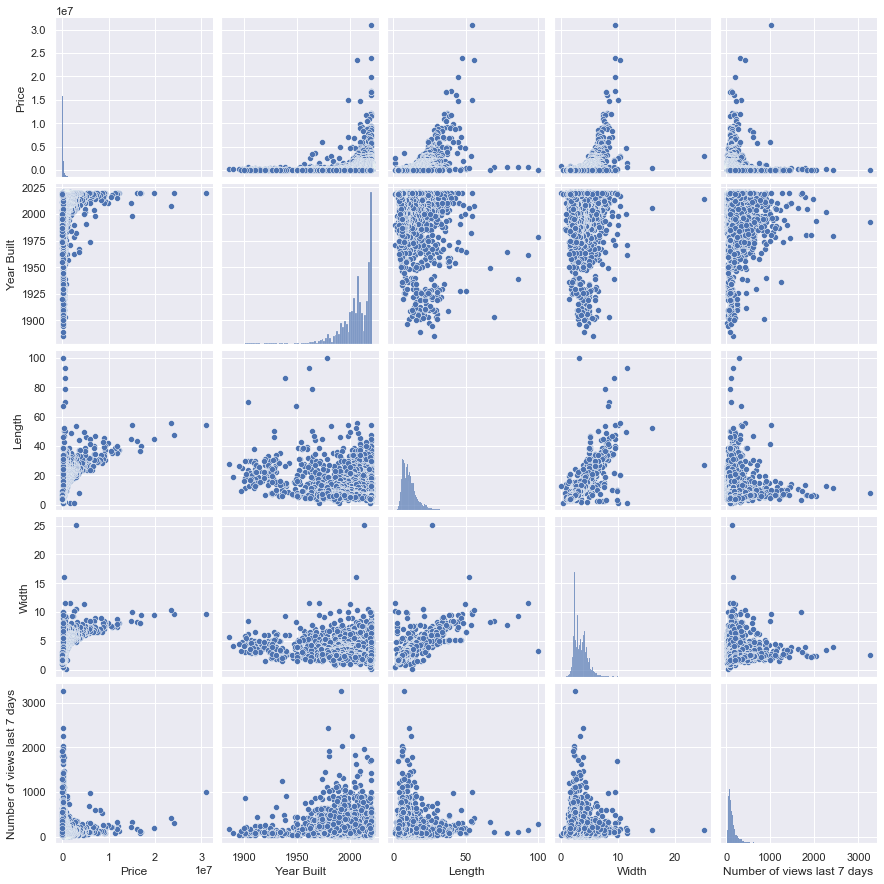

In [50]:

sns.pairplot(df2)
plt.show()

In [ ]:
# It seems like there are too many outliers in the price column. There is some positive correlation with Year Built after cleaning.

Text(0.5, 1.0, 'Vies Distribution')

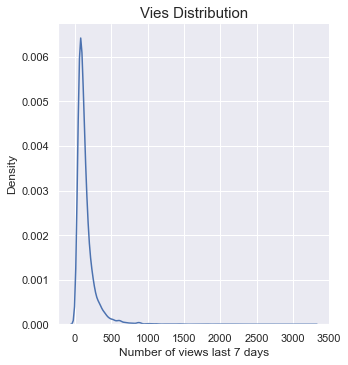

In [63]:
# Number of views
sns.displot(df2['Number of views last 7 days'],kind='kde' )
plt.title('Views Distribution', size=15)

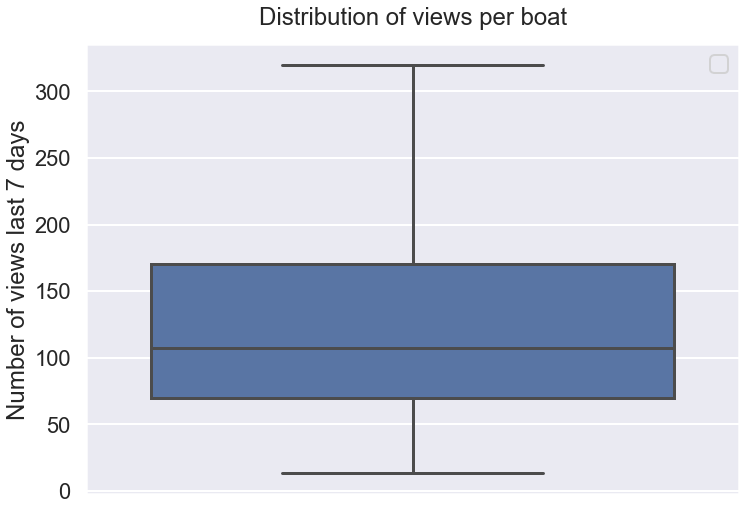

In [65]:
# the distribution looks like normal skewed to the right

# boxplot
sns.set_context('poster')
g = sns.boxplot(y='Number of views last 7 days', data = df2, showfliers = False)

g.set(ylabel='Number of views last 7 days')

g.set_title('Distribution of views per boat', y=1.03)
g.legend(loc='upper right')
plt.show()

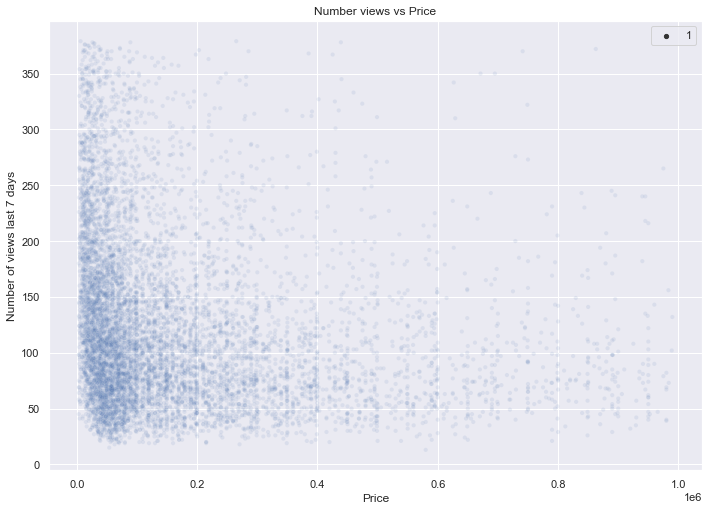

In [53]:
# price

sns.set_context('notebook')
#sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=df2.Price, y='Number of views last 7 days', data=df2[(df2.Price < df2.Price.quantile(0.95)) & (df2['Number of views last 7 days'] < df2['Number of views last 7 days'].quantile(0.95))], size=1, alpha=0.1)
plt.title('Number views vs Price')
plt.show()

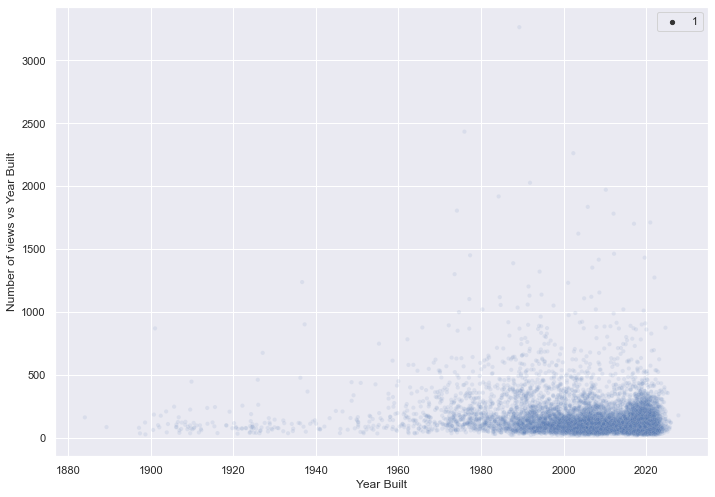

In [55]:
# Year

# add some jittering
df_jit = df2.copy()
df_jit['Year Built'] = df_jit['Year Built'].astype('int64') + np.random.normal(0, 2, size=len(df_jit))

sns.set_context('notebook')
g=sns.scatterplot(x='Year Built', y='Number of views last 7 days', data=df_jit, size=1, alpha=0.1)
g.set(ylabel='Number of views vs Year Built')
plt.show()

In [57]:
df2.dtypes

Price                          float64
Boat Type                       object
Manufacturer                    object
Year Built                       int64
Length                         float64
Width                          float64
Material                        object
Location                        object
Number of views last 7 days      int64
fuel                            object
new_used                        object
dtype: object

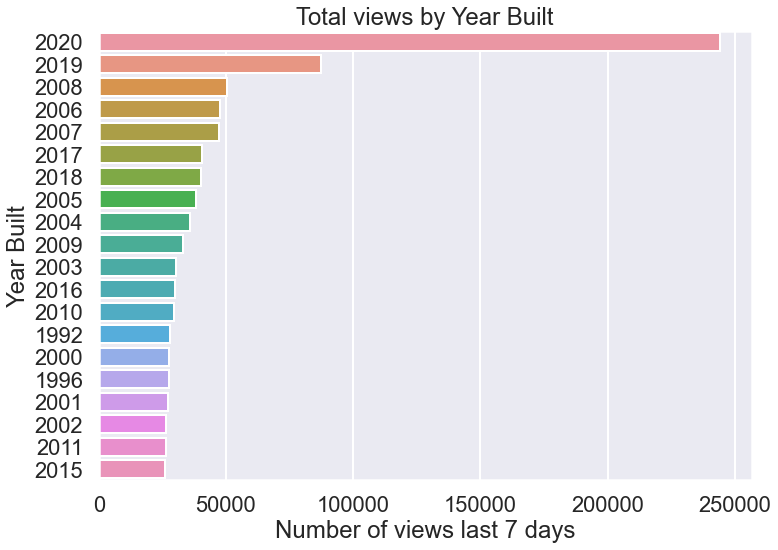

In [66]:
# another visualization
dfpl = df2.copy()
dfpl['Year Built'] = dfpl['Year Built'].astype('category')
dfpl = dfpl.groupby('Year Built')['Number of views last 7 days'].sum().sort_values(ascending=False).reset_index().head(20).copy()
plot_order = dfpl['Year Built']

sns.barplot(y='Year Built', x='Number of views last 7 days', data=dfpl, order=plot_order)
plt.title('Total views by Year Built')
plt.show()

It's necessary to point out that observing total quantity of views inside a category might not be exactly what we want. The subject of our study is a potential of an individual boat with no relationship to the category it belongs to. So it would be correct to use a median when looking at the plots.

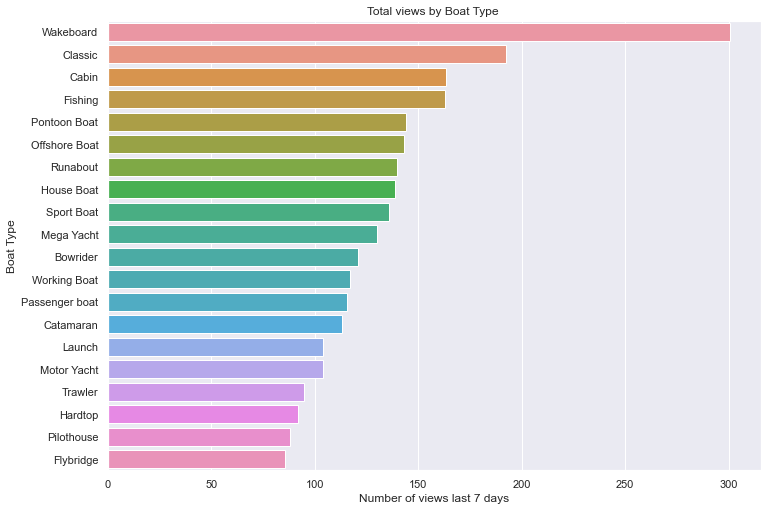

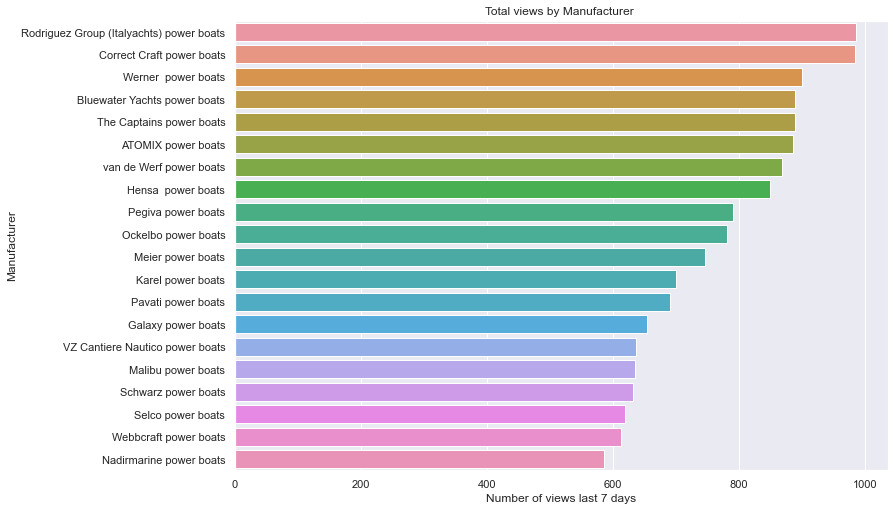

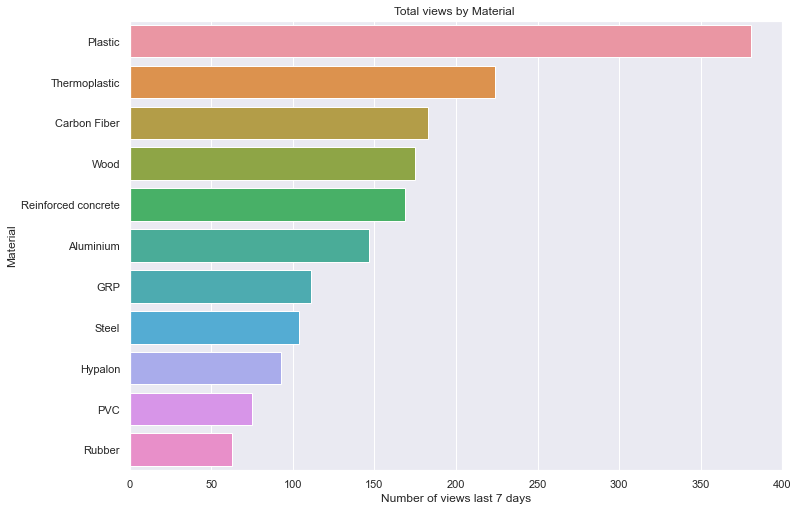

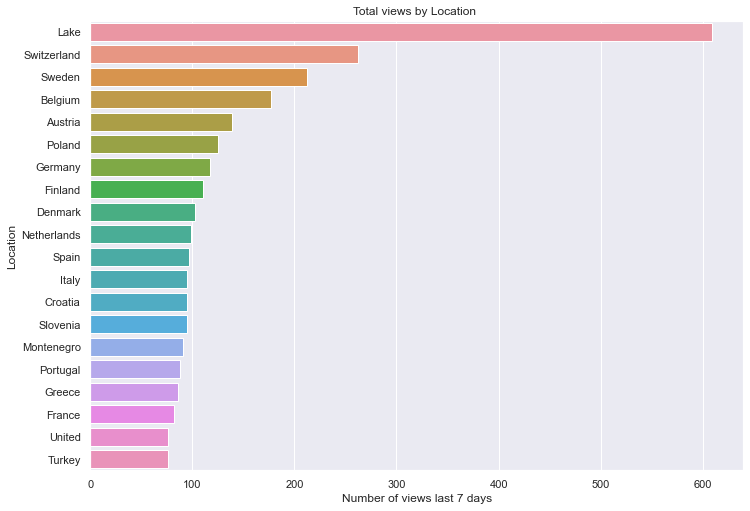

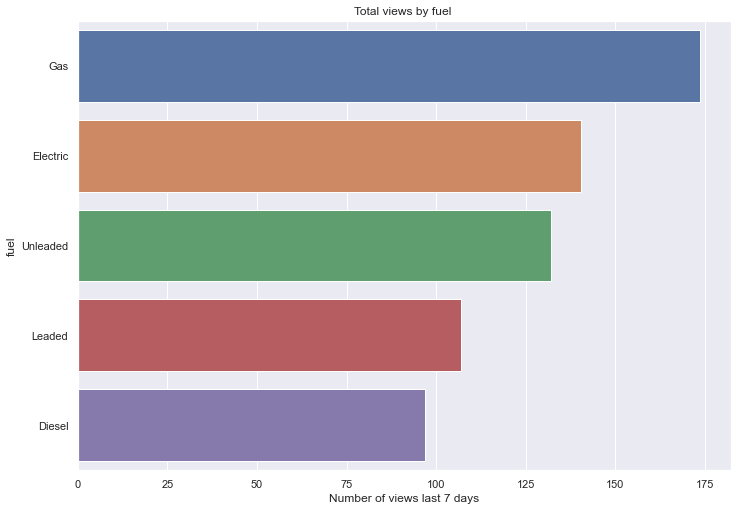

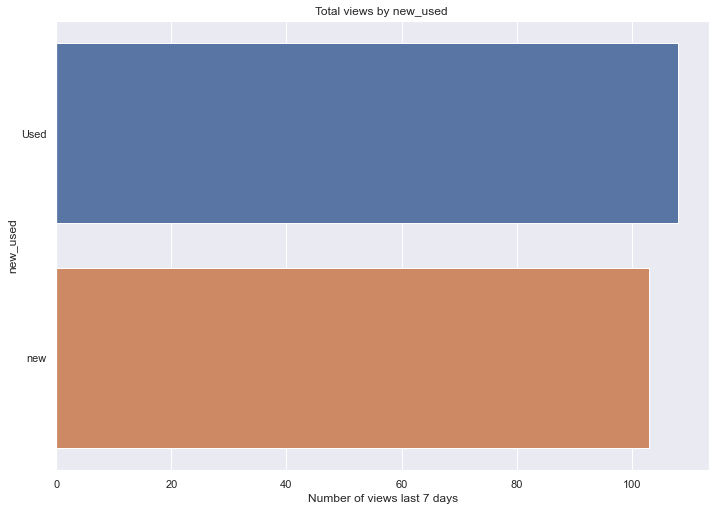

In [70]:
def plot_bars(my_col):
    dfpl = df2.groupby(my_col)['Number of views last 7 days'].median().sort_values(ascending=False).reset_index().head(20).copy()
    plot_order = dfpl[my_col]
    sns.set_context('notebook')
    sns.barplot(y=my_col, x='Number of views last 7 days', data=dfpl, order=plot_order)
    plt.title('Total views by {} '.format(my_col))
    plt.show()
for i in list(df2.select_dtypes(include=['object']).columns):
    plot_bars(i)

# Baseline Model

In [99]:
# check the dataframe
df2.head()

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,fuel,new_used,Number of views last 7 days
0,3.476042,Motor Yacht,Rigiflex power boats,2017,4.00,1.90,GRP,Switzerland,Leaded,new,226
1,3.490000,Center console boat,Terhi power boats,2020,4.00,1.50,Thermoplastic,Germany,Leaded,new,75
2,3.927083,Sport Boat,Marine power boats,2020,3.69,1.42,Aluminium,Switzerland,Leaded,new,124
3,3.481183,Sport Boat,Pioner power boats,2020,3.00,1.00,GRP,Denmark,Leaded,new,64
4,3.399000,Fishing,Linder power boats,2019,3.55,1.46,Aluminium,Germany,Leaded,new,58


In [100]:
df2.dtypes

Price                          float64
Boat Type                       object
Manufacturer                    object
Year Built                       int64
Length                         float64
Width                          float64
Material                        object
Location                        object
fuel                            object
new_used                        object
Number of views last 7 days      int64
dtype: object

Since this problem is a multivariate regression problem, for the Baseline Model I traditionally chose Linear Regression

In [101]:
df3 = df2.copy()

le = LabelEncoder() # I will use Label Encoder for the object cols

my_object_cols = list(df3.select_dtypes(include=['object']).columns.values)
for i in my_object_cols:
    df3[i] = le.fit_transform(df3[i])
    
scaler = MinMaxScaler() # instantiate MinMaxScaler

# Create features and target variables
X = scaler.fit_transform(df3.iloc[:, :-1])
y = df3.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y) # split the data into train and test datasets

#==================MODEL====================

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
scores = cross_val_score(lr, X, y, cv=10, scoring=my_metric)
scores = -scores # cross val score returns the negative errors
print('Linear Regression MAPE =', scores.mean())

Linear Regression MAPE = 0.7644199726610721


We got around 75% mean absolute percentage error which is not so bad for a baseline model. Now let's try to figure out what model we would like to use for this particular problem. This is not a one time analysis, obviously Nearly New Nautical wants to make this model part of the decision making process on an ongoing basis. Thus, our model has to be flexible to consume new data. Secondly, we can see our dataset is not ideally clean, so we need a model that want collapse if some unexcpected data come. Since our client this the Marketing Department we have to be ready to explain how exactly our model works to non-technical co-workers, which means our model should be relatively easy to understand and interpret. The model that matches all theses requirements is Random Forest Regressor.  
However, Random Forest algortithm has its limitations: it does not extrapolate beyond the training set. The predictions are always in the range of the training set.

# Random Forest Regressor

In [21]:
df3 = df2.copy()

ohe = OneHotEncoder(handle_unknown='ignore')

X = df3.iloc[:, :-1]
y = df3.iloc[:, -1]


# Since I'm going to use a Pipeline I want to explicitly define my categorical and numerical features

my_object_cols = list(X.select_dtypes(include=['object']).columns.values)
my_other_cols = list((set(X.columns)) - (set(my_object_cols)))

# OneHotEncoder usually demands data to be categorical type
for i in my_object_cols:
    df3[i] = df3[i].astype('category')
    
#=====================================

column_trans = make_column_transformer((ohe, my_object_cols), remainder='passthrough')
rf = RandomForestRegressor(n_estimators=100)
pipe = make_pipeline(column_trans, rf)

We created a Pipeline, now let's evaluate our model according to the metric the Product Manager indicated in his technical task - MAPE (Mean Average Percentage Error)

In [124]:
cross_val_score(pipe, X, y, cv=10, scoring=my_metric).mean()

-0.48886674525980467

Our Random Forest regressor not only outperformed the Baseline Model but it also satisfied the customer's requirement: on average, the predictions have to be only 50% off of the true number. 10-fold validation was slightly computationaly expensive, but it paid off, now we are sure this is not just a random result.
But just a good model performance is not very useful in itself, it is important how we can apply it to solve our business problem.
Let's see how the model works on a specific example. First, let's take some data from the training set.

## Test on existing data

In [22]:
# split X and y and fit pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Boat Type', 'Manufacturer',
                                                   'Material', 'Location',
                                                   'fuel', 'new_used'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [135]:
# let's randomly choose some data
X_new = X_test.sample(5, random_state=89)
X_new.join(y)

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,fuel,new_used,Number of views last 7 days
7022,75.000000,Pilothouse,Rhea power boats,2006,9.30,3.30,PVC,France,Diesel,Used,81
8735,36.458333,Classic,Swiss Craft power boats,1956,9.00,2.80,Wood,Switzerland,Unleaded,Used,423
3497,1750.000000,Motor Yacht,Sunseeker power boats,2009,26.25,6.35,GRP,France,Diesel,Used,67
2718,325.000000,Motor Yacht,BÃ©nÃ©teau power boats,2013,13.41,3.96,unknown,Malta,Leaded,Used,83
65,6.500000,Classic,unknown,1975,6.67,2.04,Wood,Spain,Unleaded,Used,184


In [136]:
# now we use perdict method to predict the number of views for these 5 boats
y_new = pipe.predict(X_new)

# let's add the predictions to the dataframe to make it easier to compare
X_new.join(y).assign(predicted = y_new)

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,fuel,new_used,Number of views last 7 days,predicted
7022,75.000000,Pilothouse,Rhea power boats,2006,9.30,3.30,PVC,France,Diesel,Used,81,97.730000
8735,36.458333,Classic,Swiss Craft power boats,1956,9.00,2.80,Wood,Switzerland,Unleaded,Used,423,413.320000
3497,1750.000000,Motor Yacht,Sunseeker power boats,2009,26.25,6.35,GRP,France,Diesel,Used,67,80.030000
2718,325.000000,Motor Yacht,BÃ©nÃ©teau power boats,2013,13.41,3.96,unknown,Malta,Leaded,Used,83,69.399405
65,6.500000,Classic,unknown,1975,6.67,2.04,Wood,Spain,Unleaded,Used,184,232.690000


As we can see the model works pretty decently. Now let's try to simulate how it can be integrated to the decision making process

## New Data

I made up some arbitrary date

In [23]:
new_data = {
    'Price': 88,
    'Boat Type': 'Catamaran',
    'Manufacturer': 'unknown',
    'Year Built': '2015',
    'Length': 10,
    'Width': 2.4,
    'Material': 'GRP',
    'Location': 'France',
    'fuel': 'Diesel',
    'new_used': 'Used' }

ndf = pd.DataFrame(new_data, index=[0])
ndf

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,fuel,new_used
0,88,Catamaran,unknown,2015,10,2.4,GRP,France,Diesel,Used


In [24]:
# Let's predict the number of views for this new boat
pipe.predict(ndf)[0]

165.24

## Decision Making

We want to define some threshold below which we do not want to fall

In [25]:
views_threshold = 0.2 # quantile

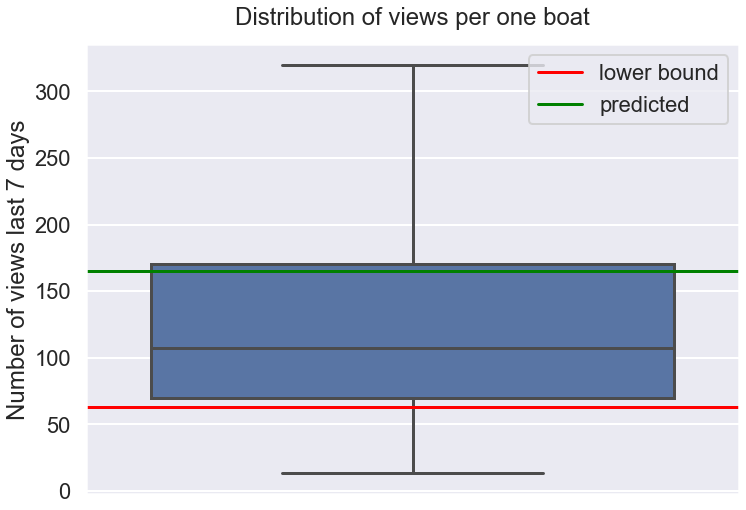

In [27]:
df_sea = df3.copy()
df_sea.rename(columns={'Number of views last 7 days':'v'}, inplace=True)

sns.set_context('poster')
g = sns.boxplot(y='v', data = df_sea, showfliers = False)

g.axhline(df_sea.v.quantile(views_threshold), color='red', label='lower bound')
g.axhline(pipe.predict(ndf)[0], color='green', label='predicted')

g.set(ylabel='Number of views last 7 days')
#plt.title('Distribution of views per item')
g.set_title('Distribution of views per one boat', y=1.03)
g.legend(loc='upper right')
plt.show()

The boxplot gives us an intuition about the entire distribution and the green and red lines support the decision. It's just a vusialization of the idea, of course, if accepted, the model is supposed to work automatically. 

# Conclusion

The goal of the project was to develop a model that would predict the number of views with decent accuracy, and in addition,  to offer a tool for filtering products from getting into the listing.  
After data cleaning and feature engineering model performed with 48.9% MAPE which, according to the customer task is enough. While this fits the task, there is still a lot of work could be done in the model in terms both of feature engineering (Material, Manufacturer etc) and model tuning (GridSearch, Bagging etc).  
This task can be a good start for a more ambitious task: determining the optimal listing to maximize the company's profits. This will require more structured data (including views conversion) and will require insights and restrictions from marketing and sales department experts.

### The code only

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.read_csv('data/boat_data.csv')

# Looks like the Mean Absolute Percentage Error (MAPE) will meet the PM's expectations
my_metric = 'neg_mean_absolute_percentage_error'


#==================BOAT TYPE====================

df1 = df.copy()
# apperently we have five main groups that have lots of derivatives which can by replaced by key words: Motor Yacht, Sport Boat, Classic and Cabin boat. Let's unify them

boat_type_keywords = ['Motor Yacht', 'Sport Boat', 'Classic', 'Cabin', 'Wakeboard', 'Fishing', 'Center console boat', 'Passenger boat', 'Bowrider', 'Deck Boat', 'Flybridge', 'Offshore Boat']

def unify_boat_type(my_keywords = boat_type_keywords):
    
    '''sequentially replaces group names according to the order in the boat_type_keywords list '''
    
    df1['Boat Type'] = df1['Boat Type'].str.strip()
    
    for i in my_keywords:
        df1.loc[df1['Boat Type'].str.contains(i), 'Boat Type'] = i
        
unify_boat_type()

#==================YEAR====================

df1['Year Built'].replace(0, 2021, inplace=True)
df1['Year Built'] = df1['Year Built'].astype('object')

#==================LOCATION====================

df1['Location'] = df.Location.str.split().str[0]

#==================PRICE====================

df1.Price.str.split().str[0].value_counts().index.to_list()

curr_dict = {
   'EUR': 1,
   'CHF': 0.96,
   'Â£': 0.85,
   'DKK': 7.44    
}
df1['Price'] = df1.Price.str.split().str[1].astype('int64') / df1.Price.str.split().str[0].map(curr_dict) 
df1['Price'] = df1['Price']/1000

#==================FUEL====================

df1.Type.fillna('Used boat,Diesel', inplace=True)
fuel_keywords = ['Diesel', 'Leaded', 'Unleaded', 'Gas', 'Electric', 'Hybrid', 'Propane']
df1['fuel'] = pd.Series(dtype='object')

def create_fuel(my_keywords = fuel_keywords):    
    
    '''sequentially find boat fuel type according to the order in the boat_type_keywords list and record it to df1.fuel '''    
       
    for i in my_keywords:        
        df1.loc[df1.Type.str.contains(i), 'fuel'] = i
    df1.fuel.fillna('Leaded', inplace=True)

create_fuel()


#new/used

df1['new_used'] = df1.Type.str.split().str[0]
df1.loc[(df1.new_used != 'new') & (df1.new_used != 'Used'), 'new_used'] = 'Used'

df1.drop(columns=['Type'], inplace=True)
         
#==================MANUFACTURER AND MATERIAL====================

df2 = df1.copy()
imputer = SimpleImputer(strategy='constant', fill_value='unknown')
df2['Manufacturer'] = imputer.fit_transform(df2.Manufacturer.values.reshape(-1, 1))
df2['Material'] = imputer.fit_transform(df2.Material.values.reshape(-1, 1))

#======================================

df2.dropna(inplace=True)

cols_order = [col for col in df2.columns if col != 'Number of views last 7 days'] + ['Number of views last 7 days']
df2 = df2[cols_order]


# let's drop rows with rare countries, boat groups, fuel
good_locs = df2.Location.value_counts()[df2.Location.value_counts() > 10].index.to_list()
good_boat_types = df2['Boat Type'].value_counts()[df2['Boat Type'].value_counts() > 10].index.to_list()
good_fuel = df2.fuel.value_counts()[df2.fuel.value_counts() > 10].index.to_list()

df2 = df2[(df2.Location.isin(good_locs)) & (df2['Boat Type'].isin(good_boat_types)) & (df2.fuel.isin(good_fuel))]

#==================ENCODE====================

df3 = df2.copy()
le = LabelEncoder()
ohe = OneHotEncoder(handle_unknown='ignore')

# #OneHotEnconder demands cols to be categorical

X = df3.iloc[:, :-1]
y = df3.iloc[:, -1]

#OneHotEnconder demands cols to be categorical
my_object_cols = list(X.select_dtypes(include=['object']).columns.values)
my_other_cols = list((set(X.columns)) - (set(my_object_cols)))
#my_other_cols.remove('Number of views last 7 days')

for i in my_object_cols:
    df3[i] = df3[i].astype('category')
    
#===================PIPELINE==================

column_trans = make_column_transformer((ohe, my_object_cols), remainder='passthrough')
rf = RandomForestRegressor(n_estimators=100)
pipe = make_pipeline(column_trans, rf)
cross_val_score(pipe, X, y, cv=3, scoring=my_metric)

array([-0.48990178, -0.48326029, -0.46388743])